In [1]:
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config = config)
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from keras.utils.np_utils import to_categorical
import keras
import time
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import shutil
tStart = time.time()

/home/tsai/anaconda3/envs/tensorflow/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def Model2(config):
    filt_size = (3, 3)
    model2 = Sequential()
    model2.add(Convolution2D(32, filt_size, input_shape=config.dim, activation='relu', padding='same'))
    print(config.dim)
    model2.add(Convolution2D(32, filt_size, activation='relu', padding='same'))
    model2.add(BatchNormalization())
    model2.add(MaxPooling2D((2,2)))
    model2.add(Dropout(0.1))
    
    model2.add(Convolution2D(64, filt_size, activation='relu', padding='same'))
    model2.add(Convolution2D(64, filt_size, activation='relu', padding='same'))
    model2.add(BatchNormalization())
    model2.add(MaxPooling2D((2,2)))
    model2.add(Dropout(0.3))
    
    model2.add(Convolution2D(128, filt_size, activation='relu', padding='same'))
    model2.add(Convolution2D(128, filt_size, activation='relu', padding='same'))
    model2.add(Convolution2D(128, filt_size, activation='relu', padding='same'))
    model2.add(BatchNormalization())
    model2.add(MaxPooling2D((2,2)))
    model2.add(Dropout(0.4))
    
    model2.add(Convolution2D(256, filt_size, activation='relu', padding='same'))
    #model2.add(Convolution2D(256, filt_size, activation='relu', padding='same'))
    #model2.add(Convolution2D(256, filt_size, activation='relu', padding='same'))
    model2.add(BatchNormalization())
    model2.add(MaxPooling2D((2,2)))
    model2.add(Dropout(0.5))
    
    
    model2.add(Flatten())
    model2.add(Dense(128, activation='relu'))
    model2.add(BatchNormalization())
    model2.add(Dropout(0.5))
    model2.add(Dense(64, activation='relu'))
    model2.add(BatchNormalization())
    model2.add(Dropout(0.5))
    model2.add(Dense(1))
    model2.add(Activation('linear'))
    
    opt = optimizers.Adam(config.learning_rate)

    model2.compile(optimizer=opt, loss=keras.losses.mean_squared_error, metrics=['acc'])
    return model2

def _shuffle(X, Y):
    randomize = np.arange(len(X))
    np.random.shuffle(randomize)

    return (X[randomize], Y[randomize])

def _shuffle(X):
    randomize = np.arange(len(X))
    np.random.shuffle(randomize)

    return X[randomize]

def split_valid_set(X_all, Y_all, percentage):
    all_data_size = len(X_all)
    valid_data_size = int(math.floor(all_data_size * percentage))

    X_all, Y_all = _shuffle(X_all, Y_all)

    X_train, Y_train = X_all[0:valid_data_size], Y_all[0:valid_data_size]
    X_valid, Y_valid = X_all[valid_data_size:], Y_all[valid_data_size:]

    return X_train, Y_train, X_valid, Y_valid


def split_valid_index(total_len, percentage):
    all_data_size = total_len
    valid_data_size = int(math.floor(all_data_size * percentage))

    x = np.arange(total_len)
    x_all = _shuffle(x)

    return x_all[0:valid_data_size], x_all[valid_data_size:]

In [5]:

train = pd.read_csv('./data/train_responses.csv')

print(train.head)


<bound method NDFrame.head of               id      corr
0       arjskzyc -0.457810
1       jrsnrkcp -0.523113
2       hycqmekg -0.179033
3       cerpyxxj  0.251509
4       cohtzuog  0.353992
5       cwtadyfn  0.836124
6       daujzamk -0.314117
7       pnmvrfuu -0.190036
8       glsmhkti -0.007892
9       aiclljvq  0.512690
10      rylxkznl -0.696088
11      gqjuhjws -0.638477
12      epvlqiis  0.389008
13      iwbpyxvb  0.743324
14      pyhfmxlc  0.303286
15      pgxzxsdi  0.586874
16      slubxgrv  0.475057
17      lidauyoo  0.658084
18      nltzsvfb -0.268688
19      izbphdha  0.197823
20      pmgybapv  0.425564
21      nwqknoxd  0.293985
22      dkedqdcp -0.302821
23      byevwzsu -0.423064
24      mktnwfth  0.028941
25      mexkncgc  0.183539
26      sjeopusm  0.697128
27      nljwwobu  0.136955
28      rqgwidvx  0.654922
29      khzgvcka  0.244616
...          ...       ...
149970  ebnzzdzn -0.082571
149971  fvrjgkza  0.720507
149972  efexjbyn -0.384605
149973  kkicsutq -0.35342

In [6]:
from keras.utils import Sequence, to_categorical
from keras import backend as K

In [7]:
class Config(object):
    def __init__(self, learning_rate=0.0001, max_epochs=50, dim = (150, 150, 3), n_folds = 5):
    
       
        self.learning_rate = learning_rate
        self.max_epochs = max_epochs
        self.dim = dim
        self.n_folds = n_folds

In [9]:
class DataGenerator(Sequence):
    def __init__(self, config, data_dir, list_IDs, labels=None, 
                 batch_size=64, preprocessing_fn=lambda x: x):
        self.config = config
        self.data_dir = data_dir
        self.list_IDs = np.arange(len(list_IDs))
        self.list_Names = list_IDs
        self.labels = labels
        self.batch_size = batch_size
        self.on_epoch_end()
        self.dim = self.config.dim

    def __len__(self):
        return int(np.ceil(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        return self.__data_generation(list_IDs_temp)

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))

    def __data_generation(self, list_IDs_temp):
        cur_batch_size = len(list_IDs_temp)
        X = np.empty((cur_batch_size, *self.dim))

        for i, ID in enumerate(list_IDs_temp):
            file_path = self.data_dir + self.list_Names[ID] + '.png'
            #print(file_path)
            
            # Read and Resample the audio
            data = mpimg.imread(file_path)

            X[i,] = data
        #print(list_IDs_temp)
        if self.labels is not None:
            y = np.empty(cur_batch_size, dtype=float)
            for i, ID in enumerate(list_IDs_temp):
                y[i] = self.labels[ID]
            return X, y
        else:
            return X

In [10]:
config = Config(learning_rate=0.001,  dim = (150, 150, 3))

In [11]:
# In[3]:

from keras.models import Sequential
from keras import optimizers
from keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D,BatchNormalization, Dropout
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import StratifiedKFold

from keras.callbacks import (EarlyStopping, LearningRateScheduler,
                             ModelCheckpoint, TensorBoard, ReduceLROnPlateau)



In [12]:
PREDICTION_FOLDER = "first-prediction"
if not os.path.exists(PREDICTION_FOLDER):
    os.mkdir(PREDICTION_FOLDER)
if os.path.exists('logs/' + PREDICTION_FOLDER):
    shutil.rmtree('logs/' + PREDICTION_FOLDER)

In [13]:
train_split, test_split = split_valid_index(len(train.id), 0.3)

train_set = train.iloc[train_split].reset_index()
test_set = train.iloc[test_split].reset_index()


training_split, val_split = split_valid_index(len(train_set.id), 0.33)

training_set = train_set.iloc[training_split].reset_index()
#train_set
val_set = train_set.iloc[val_split].reset_index()
checkpoint = ModelCheckpoint(PREDICTION_FOLDER + 'best.h5', monitor='val_loss', verbose=1, save_best_only=True)
early = EarlyStopping(monitor="val_loss", mode="min", patience=5)
tb = TensorBoard(log_dir='./logs/' + PREDICTION_FOLDER, write_graph=True)

callbacks_list = [checkpoint, early, tb]

model = Model2(config)

train_generator = DataGenerator(config, './data/train_imgs/', training_set.id, 
                                training_set['corr'], batch_size=48)
val_generator = DataGenerator(config, './data/train_imgs/', val_set.id, 
                              val_set['corr'], batch_size=48)

history = model.fit_generator(train_generator, callbacks=callbacks_list, validation_data=val_generator,
                             epochs=config.max_epochs, use_multiprocessing=True, workers=6, max_queue_size=20, verbose=1)


(150, 150, 3)
Epoch 1/50
310/310 [==============================] - 109s 353ms/step - loss: 1.3178 - acc: 0.0000e+00 - val_loss: 0.0367 - val_acc: 0.0000e+00

Epoch 00001: val_loss improved from inf to 0.03673, saving model to best.h5
Epoch 2/50
310/310 [==============================] - 101s 326ms/step - loss: 0.0947 - acc: 0.0000e+00 - val_loss: 0.0975 - val_acc: 0.0000e+00

Epoch 00002: val_loss did not improve from 0.03673
Epoch 3/50
310/310 [==============================] - 109s 353ms/step - loss: 0.0219 - acc: 0.0000e+00 - val_loss: 0.0315 - val_acc: 0.0000e+00

Epoch 00003: val_loss improved from 0.03673 to 0.03152, saving model to best.h5
Epoch 4/50
310/310 [==============================] - 102s 330ms/step - loss: 0.0169 - acc: 0.0000e+00 - val_loss: 0.0251 - val_acc: 0.0000e+00

Epoch 00004: val_loss improved from 0.03152 to 0.02509, saving model to best.h5
Epoch 5/50
310/310 [==============================] - 111s 358ms/step - loss: 0.0153 - acc: 0.0000e+00 - val_loss: 0.00

'\n\n\n# Save train predictions\ntrain_generator = DataGenerator(config, \'../input/freesound-audio-tagging/audio_train/\', train.index, batch_size=128,\n                                preprocessing_fn=audio_norm)\npredictions = model.predict_generator(train_generator, use_multiprocessing=True, \n                                      workers=6, max_queue_size=20, verbose=1)\nnp.save(PREDICTION_FOLDER + "/train_predictions_%d.npy"%i, predictions)\n\n# Save test predictions\ntest_generator = DataGenerator(config, \'../input/freesound-audio-tagging/audio_test/\', test.index, batch_size=128,\n                                preprocessing_fn=audio_norm)\npredictions = model.predict_generator(test_generator, use_multiprocessing=True, \n                                      workers=6, max_queue_size=20, verbose=1)\nnp.save(PREDICTION_FOLDER + "/test_predictions_%d.npy"%i, predictions)\n\n'

In [15]:
test_generator = DataGenerator(config, './data/train_imgs/', test_set.id, 
                                test_set['corr'], batch_size=24)
model.load_weights(PREDICTION_FOLDER + 'best.h5')
model.evaluate_generator(test_generator, use_multiprocessing=True, workers=6, max_queue_size=20, verbose=1)

4375/4375 [==============================] - 145s 33ms/step


[0.005305266465725643, 0.0]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 150, 150, 32)      896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 150, 150, 32)      9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 150, 150, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 75, 75, 64)        36928     
__________

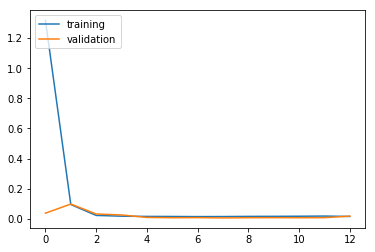

NameError: name 'X_test' is not defined

In [16]:
model.summary()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'], loc = 'upper left')
plt.show()

results = model.evaluate(X_test, y_test)



In [ ]:
pred = model.predict(kX_test)
y_ = pred.argmax(axis = -1)
output_path = 'output.csv'
with open(output_path, 'w') as f:
    f.write('id,label\n')
    for i, v in  enumerate(y_):
        f.write('%d,%d\n' %(i, v))


# In[ ]:


tEnd = time.time()
print ("It cost %f sec" % (tEnd - tStart))
print (tEnd - tStart)